# EVA8 Session 9 Assignment

## The Dawn of Transformers

### Goals
1. Create custom model with ultimus module (that contains keys, queries and values matrices)
2. Train model for 24 epochs using ADAM as optimizer
3. Use CIFAR dataset

## Install Modules

In [ ]:
!pip install albumentations==0.4.6
!pip install torchsummary
!pip install pytorch-ignite

## Clone and Import Deep Learning Utils Repo

In [ ]:
## Clone Deep Learning Utils Repo
!git clone https://github.com/a-pujahari/Torch_CV_Utils.git

In [18]:
from Torch_CV_Utils import main
from Torch_CV_Utils.utils import data_handling, train, test, gradcam, helpers, augmentation
from Torch_CV_Utils.models import custom_transformer_model
from pprint import pprint

## Import Config

In [2]:
config_file_path = "/Users/abhinavpujahari/Documents/EVA8/Torch_CV_Utils/config/config_EVA8_S9.yaml"

config = helpers.load_config_variables(config_file_path)
pprint(config)
     

 Loading config ..
 Config succesfully loaded 
{'L2_penalty': 1e-05,
 'coarseDropoutProb': 0,
 'grayscaleProb': 0,
 'horizontalFlipProb': 0,
 'maxHeight': 32,
 'maxHoles': 1,
 'maxWidth': 32,
 'minHeight': 32,
 'minHoles': 1,
 'minWidth': 32,
 'momentum_val': 0.9,
 'oneCycle_pct_start': 0.2,
 'padHeightWidth': 0,
 'randomCropProb': 0,
 'randomCropSize': 0,
 'standard_lr': 0.01}


## Perform CUDA Check, Create Device

In [3]:
device, cuda = helpers.gpu_check(seed_value = 1)
pprint(device)

CUDA unavailable
device(type='cpu')


In [4]:
# Check that MPS is available
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
    
pprint(device)

device(type='mps')


## Create Dataloaders

In [5]:
mean, std = data_handling.return_dataset_statistics()
trainloader, testloader = main.create_dataloaders(mean, std, cuda, config, augment_func = "plain_loader", gpu_batch_size = 512, cpu_batch_size = 512)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Model Summary

In [6]:
from torchsummary import summary
model = custom_transformer_model.net().to(device)
#summary(model, input_size=(3, 32, 32))

## Learning Rate Range Test - pytorch-lightning

In [7]:
from Torch_CV_Utils.utils import fastai_lr_range_test
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = config['standard_lr'], weight_decay = config['L2_penalty'])
lr_finder = fastai_lr_range_test.range_test(model, optimizer, criterion, device, trainloader, testloader,start_lr = 1e-4, end_lr = 10.0)

Epoch [1/10]: [98/98] 100%|██████████████████████, batch loss=1.93 [00:26<00:00]
Epoch [2/10]: [98/98] 100%|███████████████████████, batch loss=2.2 [00:15<00:00]
Epoch [3/10]: [98/98] 100%|██████████████████████, batch loss=1.76 [00:15<00:00]
Epoch [4/10]: [98/98] 100%|██████████████████████, batch loss=1.63 [00:15<00:00]
Epoch [5/10]: [98/98] 100%|██████████████████████, batch loss=1.59 [00:14<00:00]
Epoch [6/10]: [98/98] 100%|██████████████████████, batch loss=1.41 [00:15<00:00]
Epoch [7/10]: [98/98] 100%|███████████████████████, batch loss=1.4 [00:16<00:00]
Epoch [8/10]: [98/98] 100%|██████████████████████, batch loss=1.42 [00:15<00:00]
Epoch [9/10]: [98/98] 100%|██████████████████████, batch loss=1.33 [00:15<00:00]
Epoch [10/10]: [98/98] 100%|█████████████████████, batch loss=1.28 [00:15<00:00]


{'acc': 0.4805, 'loss': 1.37103359375}


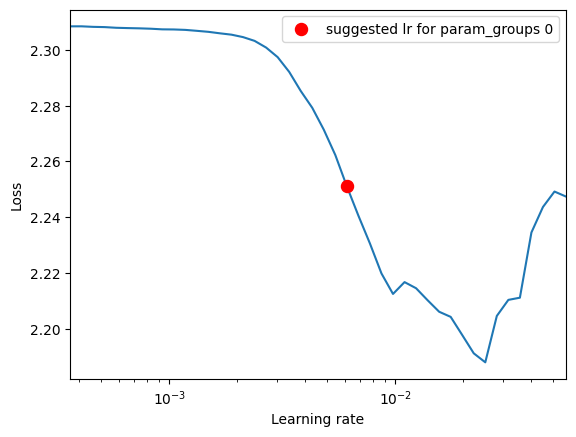

<AxesSubplot: xlabel='Learning rate', ylabel='Loss'>

In [8]:
lr_finder.plot()

In [9]:
lr_finder.lr_suggestion()

0.0061054022965853294

In [10]:
min_lr = 0.00037 ## Obtained visually from graph above
max_lr = lr_finder.lr_suggestion()
config["oneCycle_final_div"] = max_lr/(25*min_lr)
print(config["oneCycle_final_div"])

0.6600434915227383


## Trigger Training

In [11]:
config['standard_lr'] = max_lr 
print(config['standard_lr'])

0.0061054022965853294


In [12]:
train_acc, train_losses, test_acc, test_losses, lrs = main.trigger_training(model, device, trainloader, testloader, config, optimizer_name = "Adam", scheduler_name = "OneCycle", criterion_name = "CrossEntropyLoss", lambda_l1 = 0, epochs = 24)

EPOCH: 1


Loss=1.0537220239639282 Batch_id=97 LR=0.00085 Accuracy=54.65: 100%|█| 98/98 [00



Test set: Average loss: 0.0024, Accuracy: 5346/10000 (53.46%)

EPOCH: 2


Loss=1.1473230123519897 Batch_id=97 LR=0.00242 Accuracy=55.81: 100%|█| 98/98 [00



Test set: Average loss: 0.0025, Accuracy: 5369/10000 (53.69%)

EPOCH: 3


Loss=1.324575662612915 Batch_id=97 LR=0.00431 Accuracy=48.50: 100%|█| 98/98 [00:



Test set: Average loss: 0.0027, Accuracy: 4590/10000 (45.90%)

EPOCH: 4


Loss=2.3139288425445557 Batch_id=97 LR=0.00572 Accuracy=31.61: 100%|█| 98/98 [00



Test set: Average loss: 0.0048, Accuracy: 821/10000 (8.21%)

EPOCH: 5


Loss=1.5903565883636475 Batch_id=97 LR=0.00610 Accuracy=24.98: 100%|█| 98/98 [00



Test set: Average loss: 0.0033, Accuracy: 3009/10000 (30.09%)

EPOCH: 6


Loss=1.2437877655029297 Batch_id=97 LR=0.00605 Accuracy=40.98: 100%|█| 98/98 [00



Test set: Average loss: 0.0027, Accuracy: 4903/10000 (49.03%)

EPOCH: 7


Loss=2.37015962600708 Batch_id=97 LR=0.00591 Accuracy=27.88: 100%|█| 98/98 [00:1



Test set: Average loss: 0.0049, Accuracy: 1087/10000 (10.87%)

EPOCH: 8


Loss=2.017784833908081 Batch_id=97 LR=0.00569 Accuracy=15.35: 100%|█| 98/98 [00:



Test set: Average loss: 0.0042, Accuracy: 1790/10000 (17.90%)

EPOCH: 9


Loss=1.9367401599884033 Batch_id=97 LR=0.00541 Accuracy=17.92: 100%|█| 98/98 [00



Test set: Average loss: 0.0040, Accuracy: 1962/10000 (19.62%)

EPOCH: 10


Loss=2.1714067459106445 Batch_id=97 LR=0.00506 Accuracy=22.61: 100%|█| 98/98 [00



Test set: Average loss: 0.0050, Accuracy: 1326/10000 (13.26%)

EPOCH: 11


Loss=2.200700044631958 Batch_id=97 LR=0.00466 Accuracy=21.29: 100%|█| 98/98 [00:



Test set: Average loss: 0.0042, Accuracy: 1761/10000 (17.61%)

EPOCH: 12


Loss=1.8507556915283203 Batch_id=97 LR=0.00422 Accuracy=19.84: 100%|█| 98/98 [00



Test set: Average loss: 0.0037, Accuracy: 2262/10000 (22.62%)

EPOCH: 13


Loss=1.8833717107772827 Batch_id=97 LR=0.00374 Accuracy=25.35: 100%|█| 98/98 [00



Test set: Average loss: 0.0036, Accuracy: 2765/10000 (27.65%)

EPOCH: 14


Loss=1.6621544361114502 Batch_id=97 LR=0.00325 Accuracy=32.43: 100%|█| 98/98 [00



Test set: Average loss: 0.0033, Accuracy: 3528/10000 (35.28%)

EPOCH: 15


Loss=1.518742322921753 Batch_id=97 LR=0.00275 Accuracy=37.63: 100%|█| 98/98 [00:



Test set: Average loss: 0.0031, Accuracy: 3744/10000 (37.44%)

EPOCH: 16


Loss=1.780297040939331 Batch_id=97 LR=0.00226 Accuracy=28.99: 100%|█| 98/98 [00:



Test set: Average loss: 0.0036, Accuracy: 2679/10000 (26.79%)

EPOCH: 17


Loss=1.7211952209472656 Batch_id=97 LR=0.00179 Accuracy=30.17: 100%|█| 98/98 [00



Test set: Average loss: 0.0034, Accuracy: 3471/10000 (34.71%)

EPOCH: 18


Loss=1.676878809928894 Batch_id=97 LR=0.00135 Accuracy=31.46: 100%|█| 98/98 [00:



Test set: Average loss: 0.0034, Accuracy: 3518/10000 (35.18%)

EPOCH: 19


Loss=1.535071611404419 Batch_id=97 LR=0.00096 Accuracy=37.66: 100%|█| 98/98 [00:



Test set: Average loss: 0.0031, Accuracy: 3833/10000 (38.33%)

EPOCH: 20


Loss=1.5658873319625854 Batch_id=97 LR=0.00063 Accuracy=40.11: 100%|█| 98/98 [00



Test set: Average loss: 0.0030, Accuracy: 3994/10000 (39.94%)

EPOCH: 21


Loss=1.4804667234420776 Batch_id=97 LR=0.00036 Accuracy=41.66: 100%|█| 98/98 [00



Test set: Average loss: 0.0030, Accuracy: 4043/10000 (40.43%)

EPOCH: 22


Loss=1.4399409294128418 Batch_id=97 LR=0.00016 Accuracy=42.04: 100%|█| 98/98 [00



Test set: Average loss: 0.0039, Accuracy: 3908/10000 (39.08%)

EPOCH: 23


Loss=1.4467012882232666 Batch_id=97 LR=0.00004 Accuracy=42.44: 100%|█| 98/98 [00



Test set: Average loss: 0.0030, Accuracy: 4118/10000 (41.18%)

EPOCH: 24


Loss=1.469463586807251 Batch_id=97 LR=0.00000 Accuracy=42.50: 100%|█| 98/98 [00:



Test set: Average loss: 0.0030, Accuracy: 4121/10000 (41.21%)



## Plot Metrics

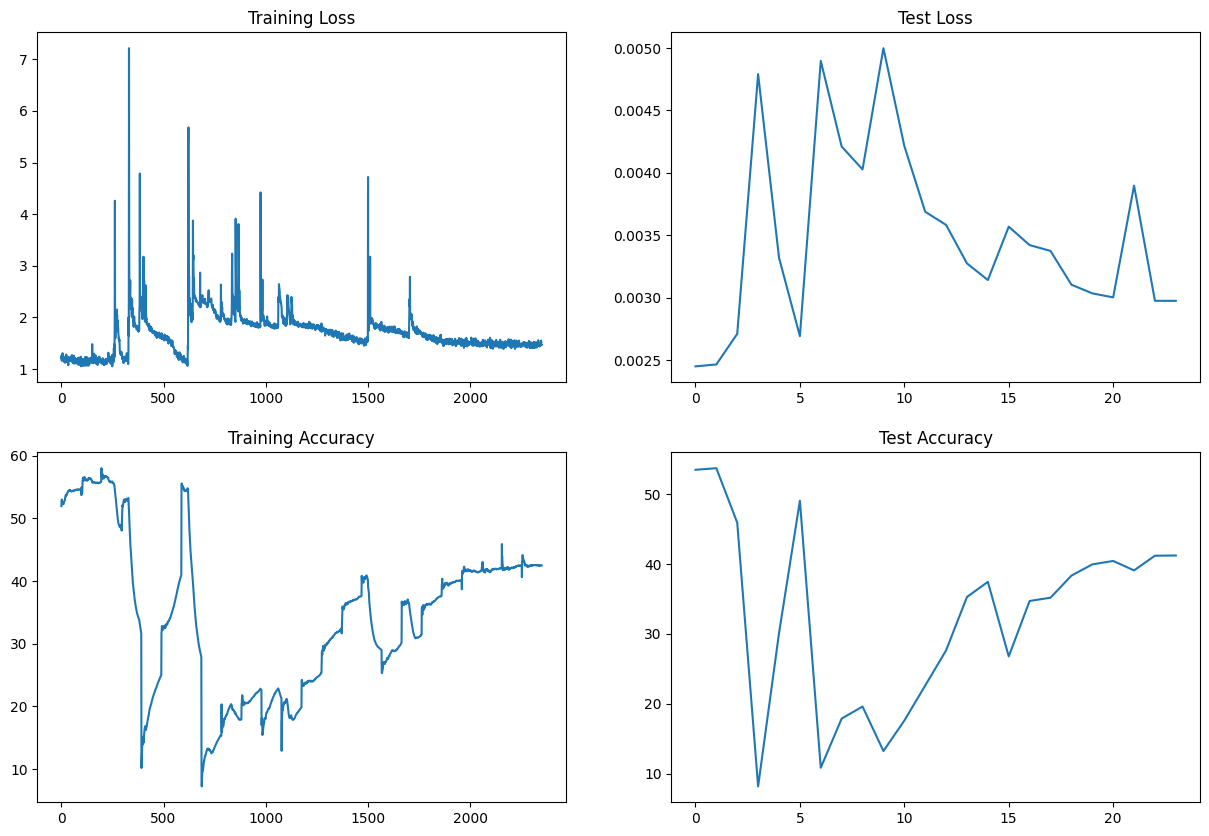

In [13]:
helpers.plot_metrics(train_acc, train_losses, test_acc, test_losses)

## Misclassified Images

/Users/abhinavpujahari/Documents/EVA8/Torch_CV_Utils/utils/helpers.py:74: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  wrong_images.append(data[wrong_pred])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 5879


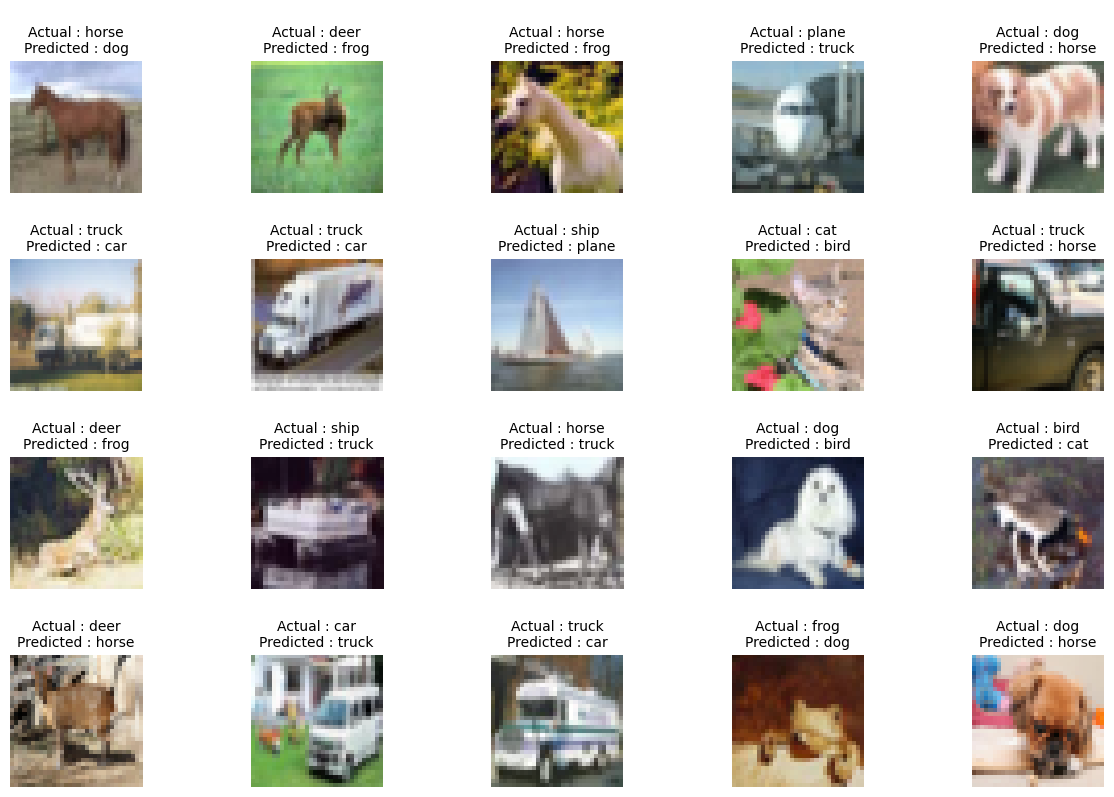

In [14]:
misclassified_images = helpers.wrong_predictions(model, testloader, device)
helpers.plot_misclassified(misclassified_images, mean, std, 20)